In this notebook:
- The environment and the hyperparameters are modified to improve performance
  - The environment will be designed for <b>MlpLstmPolicy</b>
    - Lookback periods will provide a returns HISTORY, but for the rest of the indicators only the current period
    - The reward function will use a geometric-decay based on previous actions of the agent
    - Portfolio weights will be normalized to sum to 1, with all zero-weights being penalized by a set value.
  - The randomly-selected episodes run for longer (100 time-steps)
- Again, the model is trained and tested for multiple assets and compared to the equal-weights portfolio

In [9]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sb3_contrib import RecurrentPPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.monitor import Monitor
from gymnasium import Env
from gymnasium.spaces import Discrete, Box
import matplotlib.pyplot as plt

import importlib
import library
import callbacks
importlib.reload(library)
importlib.reload(callbacks)
import library
import callbacks


TICKERS = []
def getData():
    global TICKERS

    df = library.contiguousZones(*['2/SOLUSDC.csv', '2/DOGEUSDC.csv', '2/BTCUSDC.csv'])
    TICKERS = set(ticker[0] for ticker in df.columns)

    return df

getData().head()

SOLUSDC                                    \
                       Open    High     Low   Close    Volume   
Open time                                                       
2024-08-01 00:00:00  171.58  172.89  171.26  171.42  2366.117   
2024-08-01 00:30:00  171.32  172.56  171.11  171.97  1889.412   
2024-08-01 01:00:00  171.89  172.32  171.07  171.81  1214.505   
2024-08-01 01:30:00  171.80  171.80  169.97  171.10  3871.560   
2024-08-01 02:00:00  171.18  171.54  169.44  169.56  4710.776   

                                                         \
                    Quote asset volume Number of trades   
Open time                                                 
2024-08-01 00:00:00       407105.82230            752.0   
2024-08-01 00:30:00       324621.59381            628.0   
2024-08-01 01:00:00       208544.08849            373.0   
2024-08-01 01:30:00       661030.69686            873.0   
2024-08-01 02:00:00       801793.08710           1476.0   

                                                                              \
                    Taker buy base asset volume Taker buy quote asset volume   
Open time                                                                      
2024-08-01 00:00:00                     741.076                 127524.08388   
2024-08-01 00:30:00                     910.237                 156410.54570   
2024-08-01 01:00:00                     775.572                 133211.30871   
2024-08-01 01:30:00                    1573.397                 269039.05509   
2024-08-01 02:00:00                    2556.853                 435360.79159   

                    DOGEUSDC  ...                                BTCUSDC  \
                        Open  ... Taker buy quote asset volume      Open   
Open time                     ...                                          
2024-08-01 00:00:00  0.12190  ...                   6094.38140  64614.00   
2024-08-01 00:30:00  0.12229  ...                   6024.81573  64546.00   
2024-08-01 01:00:00  0.12283  ...                   9899.16075  64624.00   
2024-08-01 01:30:00  0.12248  ...                   9801.03517  64530.01   
2024-08-01 02:00:00  0.12242  ...                  12803.79624  64182.00   

                                                             \
                         High       Low     Close    Volume   
Open time                                                     
2024-08-01 00:00:00  64789.99  64323.20  64548.00  67.26043   
2024-08-01 00:30:00  64822.00  64340.01  64626.00  46.49807   
2024-08-01 01:00:00  64792.00  64386.00  64532.00  36.50007   
2024-08-01 01:30:00  64530.01  64105.00  64182.01  68.35677   
2024-08-01 02:00:00  64238.01  63877.57  63988.01  96.48837   

                                                         \
                    Quote asset volume Number of trades   
Open time                                                 
2024-08-01 00:00:00       4.343514e+06             6344   
2024-08-01 00:30:00       3.003529e+06             6577   
2024-08-01 01:00:00       2.356451e+06             4948   
2024-08-01 01:30:00       4.392649e+06             9438   
2024-08-01 02:00:00       6.177980e+06            10371   

                                                                              
                    Taker buy base asset volume Taker buy quote asset volume  
Open time                                                                     
2024-08-01 00:00:00                    31.14047                 2.011552e+06  
2024-08-01 00:30:00                    25.19255                 1.627379e+06  
2024-08-01 01:00:00                    17.58230                 1.135151e+06  
2024-08-01 01:30:00                    27.28470                 1.753344e+06  
2024-08-01 02:00:00                    45.36551                 2.905331e+06  

[5 rows x 27 columns]

In [11]:
# BLANK FOR NOW
# (optional) put stuff in
def add_financial_indicators(df):
    for ticker in TICKERS:
        df[(ticker, "Returns")] = df[(ticker, "Open")].pct_change().shift(-1)
    return df

add_financial_indicators(getData()).head()

SOLUSDC                                    \
                       Open    High     Low   Close    Volume   
Open time                                                       
2024-08-01 00:00:00  171.58  172.89  171.26  171.42  2366.117   
2024-08-01 00:30:00  171.32  172.56  171.11  171.97  1889.412   
2024-08-01 01:00:00  171.89  172.32  171.07  171.81  1214.505   
2024-08-01 01:30:00  171.80  171.80  169.97  171.10  3871.560   
2024-08-01 02:00:00  171.18  171.54  169.44  169.56  4710.776   

                                                         \
                    Quote asset volume Number of trades   
Open time                                                 
2024-08-01 00:00:00       407105.82230            752.0   
2024-08-01 00:30:00       324621.59381            628.0   
2024-08-01 01:00:00       208544.08849            373.0   
2024-08-01 01:30:00       661030.69686            873.0   
2024-08-01 02:00:00       801793.08710           1476.0   

                                                                              \
                    Taker buy base asset volume Taker buy quote asset volume   
Open time                                                                      
2024-08-01 00:00:00                     741.076                 127524.08388   
2024-08-01 00:30:00                     910.237                 156410.54570   
2024-08-01 01:00:00                     775.572                 133211.30871   
2024-08-01 01:30:00                    1573.397                 269039.05509   
2024-08-01 02:00:00                    2556.853                 435360.79159   

                    DOGEUSDC  ...   BTCUSDC                      \
                        Open  ...       Low     Close    Volume   
Open time                     ...                                 
2024-08-01 00:00:00  0.12190  ...  64323.20  64548.00  67.26043   
2024-08-01 00:30:00  0.12229  ...  64340.01  64626.00  46.49807   
2024-08-01 01:00:00  0.12283  ...  64386.00  64532.00  36.50007   
2024-08-01 01:30:00  0.12248  ...  64105.00  64182.01  68.35677   
2024-08-01 02:00:00  0.12242  ...  63877.57  63988.01  96.48837   

                                                         \
                    Quote asset volume Number of trades   
Open time                                                 
2024-08-01 00:00:00       4.343514e+06             6344   
2024-08-01 00:30:00       3.003529e+06             6577   
2024-08-01 01:00:00       2.356451e+06             4948   
2024-08-01 01:30:00       4.392649e+06             9438   
2024-08-01 02:00:00       6.177980e+06            10371   

                                                                              \
                    Taker buy base asset volume Taker buy quote asset volume   
Open time                                                                      
2024-08-01 00:00:00                    31.14047                 2.011552e+06   
2024-08-01 00:30:00                    25.19255                 1.627379e+06   
2024-08-01 01:00:00                    17.58230                 1.135151e+06   
2024-08-01 01:30:00                    27.28470                 1.753344e+06   
2024-08-01 02:00:00                    45.36551                 2.905331e+06   

                     DOGEUSDC   BTCUSDC   SOLUSDC  
                      Returns   Returns   Returns  
Open time                                          
2024-08-01 00:00:00  0.003199 -0.001052 -0.001515  
2024-08-01 00:30:00  0.004416  0.001208  0.003327  
2024-08-01 01:00:00 -0.002849 -0.001454 -0.000524  
2024-08-01 01:30:00 -0.000490 -0.005393 -0.003609  
2024-08-01 02:00:00 -0.013233 -0.003023 -0.009464  

[5 rows x 30 columns]

In [12]:
""" THESE ARE GLOBAL VARIABLES """
SQNC_LOOKBACK = 10
SQNC_RUNFORWARD = 100
ACTION_SIZE = 0 # set by sqnc_rtns_getters
STATE_DATA_SIZE = 0 # set by sqnc_rtns_getters
STATE_INTERNAL_SIZE = 0
REWARD_DECAY = 0.8
REWARD_ZEROS_PENALTY = -1
""" OKAY??? GLOBAL!!! """


def sqnc_rtns_getters():
    global ACTION_SIZE, STATE_DATA_SIZE, TICKERS

    df = getData()
    ACTION_SIZE = len(TICKERS)

    df = add_financial_indicators(df)

    normalized_df = df.copy()
    for drop_column in ["Returns"]:
        normalized_df = normalized_df.drop(columns=[(ticker, drop_column) for ticker in TICKERS])
    normalized_df.columns = ['_'.join(col).strip() for col in normalized_df.columns.values]
    scaler = preprocessing.MinMaxScaler()
    normalized_columns = scaler.fit_transform(normalized_df)
    normalized_df = pd.DataFrame(normalized_columns, columns=normalized_df.columns, index=normalized_df.index)

    state_df = normalized_df.copy()
    # display(state_df.head())

    lookback_states = df.copy()
    for column in lookback_states.columns:
        if "Returns" not in column:
            lookback_states.drop(columns=[column], inplace=True)
    lookback_states.columns = ['_'.join(col).strip() for col in lookback_states.columns.values]
    lookback_dfs = [lookback_states.shift(i) for i in range(SQNC_LOOKBACK)]
    lookback_df = pd.concat(lookback_dfs, axis=1)
    # display(lookback_df.head())

    STATE_DATA_SIZE = len(normalized_df.columns) + len(lookback_df.columns)

    testing_index = int(len(df) * 0.8)
    def getSequence(testing=False, training=False, tryAll=False, seed=None):
        state_arrays = state_df.values
        lookback_arrays = lookback_df.values
        indices = np.arange(len(state_arrays))

        if testing:
            indices = indices[testing_index:-1]
        elif training:
            if seed:
                rng = np.random.default_rng(seed)
                randomStart = rng.integers(SQNC_LOOKBACK, testing_index - SQNC_RUNFORWARD)
            else:
                randomStart = np.random.randint(SQNC_LOOKBACK, testing_index - SQNC_RUNFORWARD)
            indices = indices[randomStart:randomStart + SQNC_RUNFORWARD]
        elif tryAll:
            indices = indices[SQNC_LOOKBACK:]
        
        blankDf = pd.DataFrame(np.zeros((len(indices), ACTION_SIZE)), index=indices)
        blankDf[:] = np.nan
        def state_generator():
            for i in indices:
                yield np.concatenate([state_arrays[i], lookback_arrays[i]])
            yield None # a courtesy most generators do not supply
            
        return { 'actions_notebook': blankDf, 'state_gen': state_generator() }

    
    def getReturns(actions):
        # actions is a time_indices-indexed df of portfolio weights, just one column for now
        returns = []
        for a_i, i in enumerate(actions.index):
            if np.isnan(actions.iloc[a_i, 0]):
                break

            period_return = 0
            for j, ticker in enumerate(TICKERS):
                period_return += actions.iloc[a_i, j] * df.iloc[i][(ticker, "Returns")]
            returns.append(period_return)
        return returns
    
    return getSequence, getReturns
    

getSequence, getReturns = sqnc_rtns_getters()

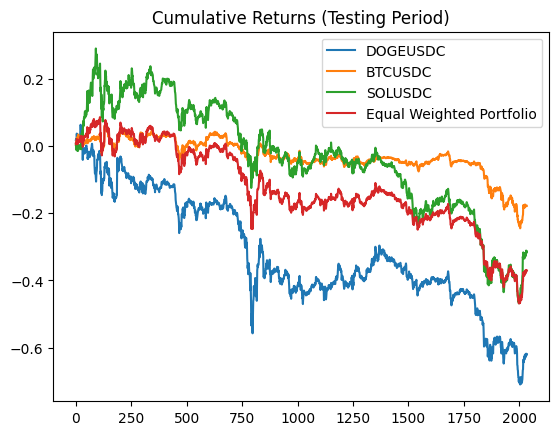

In [13]:
notebook = getSequence(testing=True)['actions_notebook']
notebook.head()

# for ticker in TICKERS:
#     df = add_financial_indicators(getData())
#     testingIndex = int(len(df) * 0.8)
#     df = df.iloc[testingIndex:]
#     plt.plot(np.cumsum(df[(ticker, "Returns")]), label=ticker)
# plt.show()

for i, ticker in enumerate(TICKERS):
    notebook.iloc[:, :] = 0
    notebook.iloc[:, i] = 1
    plt.plot(np.cumsum(getReturns(notebook)), label=ticker)

notebook.iloc[:, :] = 1/ACTION_SIZE
plt.plot(np.cumsum(getReturns(notebook)), label='Equal Weighted Portfolio')
plt.title("Cumulative Returns (Testing Period)")
plt.legend()

In [14]:
def setFirstNA(df, value):
    first_na_index = df[df.isna().any(axis=1)].index[0]
    df.loc[first_na_index] = value
    return df

class PortfolioEnv(Env):
    def __init__(self, seed=None, testing=False):
        super(PortfolioEnv, self).__init__()

        global ACTION_SIZE, STATE_DATA_SIZE, STATE_INTERNAL_SIZE

        self.action_space = Box(low=0, high=1, shape=(ACTION_SIZE,), dtype=np.float64)
        self.observation_space = Box(low=0, high=1, shape=(STATE_DATA_SIZE + STATE_INTERNAL_SIZE,), dtype=np.float64)
        
        self.testing = testing
        self.training = 1 - self.testing
        d = getSequence(training=self.training, testing=self.testing, seed=seed)
        self.sequenceGen = d['state_gen']
        self.actionsNotebook = d['actions_notebook']
        self.state = self.sequenceGen.__next__()

    def step(self, action):
        global REWARD_DECAY, REWARD_ZEROS_PENALTY

        action = action / (np.sum(action) if np.sum(action) != 0 else 1)
        setFirstNA(self.actionsNotebook, action)
        
        returns = getReturns(self.actionsNotebook)
        reward = np.sum([r * REWARD_DECAY**i for i, r in enumerate(returns[::-1])])
        if np.sum(action) == 0:
            reward = REWARD_ZEROS_PENALTY
        
        self.state = self.sequenceGen.__next__()
        terminated = False
        truncated = False if self.state is not None else True
        return self.state, reward, terminated, truncated, {}

    def reset(self, seed=None, testing=False):
        super().reset(seed=seed)
        
        d = getSequence(training=self.training, testing=self.testing, seed=seed)
        self.sequenceGen = d['state_gen']
        self.actionsNotebook = d['actions_notebook']
        self.state = self.sequenceGen.__next__()
        return self.state, {}
    
env = DummyVecEnv([lambda: callbacks.CustomMonitor(PortfolioEnv(), 'callbacks/')])

In [15]:
SQNC_LOOKBACK = 10
SQNC_RUNFORWARD = 200
REWARD_DECAY = 0.95
REWARD_ZEROS_PENALTY = -0.1
model = RecurrentPPO("MlpLstmPolicy",
    env=env,
    verbose=1,
    n_steps=SQNC_RUNFORWARD,  # Episode length
    batch_size=SQNC_RUNFORWARD,
    n_epochs=10,
    learning_rate=0.0001,
    ent_coef=0.01,
    policy_kwargs={"lstm_hidden_size": 128}  # Optional: customize LSTM
)

callbacks.startDualWrite('callbacks/monitor.txt')
model.learn(total_timesteps=50000)
callbacks.stopDualWrite()

Using cpu device
----------------------------
| time/              |     |
|    fps             | 14  |
|    iterations      | 1   |
|    time_elapsed    | 14  |
|    total_timesteps | 200 |
----------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 10            |
|    iterations           | 2             |
|    time_elapsed         | 36            |
|    total_timesteps      | 400           |
| train/                  |               |
|    approx_kl            | 2.9923916e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -4.26         |
|    explained_variance   | 0.00491       |
|    learning_rate        | 0.0001        |
|    loss                 | -0.015        |
|    n_updates            | 10            |
|    policy_gradient_loss | -0.000336     |
|    std                  | 1             |
|    value_loss           | 0.08

KeyboardInterrupt: 

In [ ]:
model.save("(2b) best-yet-50k-steps")

[400] [-0.0417]


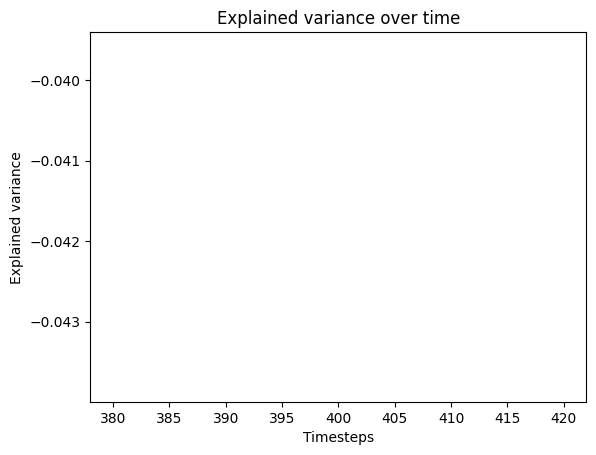

In [8]:
callbacks.plotExplainedVariance()

In [31]:

test_env = DummyVecEnv([lambda: PortfolioEnv(testing=True)])
obs = test_env.reset()
cumulativeReturns = []
actions = getSequence(testing=True)['actions_notebook']
sums = []
done = False
i = 0
while not done:
    i += 1
    if i % 100 == 0:
        print(f"Step {i}")
    action, _ = model.predict(obs, deterministic=True)
    sums.append(*action)
    obs, reward, done, _ = test_env.step(action)
    cumulativeReturns.append(reward)
    setFirstNA(actions, action)

Step 100
Step 200
Step 300
Step 400
Step 500
Step 600
Step 700
Step 800
Step 900
Step 1000
Step 1100
Step 1200


KeyboardInterrupt: 

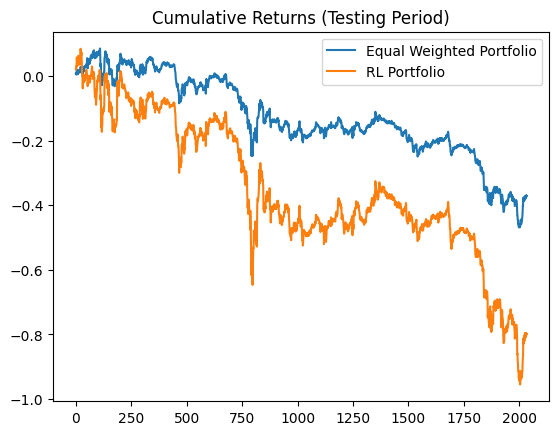

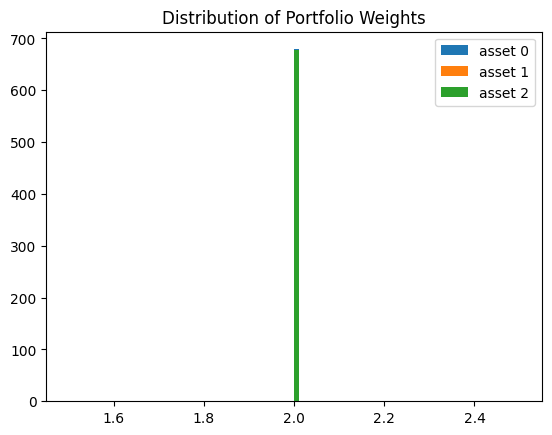

In [29]:
notebook = getSequence(testing=True)['actions_notebook']
notebook.head()

notebook.iloc[:, :] = 1/ACTION_SIZE
plt.plot(np.cumsum(getReturns(notebook)), label='Equal Weighted Portfolio')
plt.plot(np.cumsum(getReturns(actions)), label='RL Portfolio')
plt.title("Cumulative Returns (Testing Period)")
plt.legend()
plt.show()

for i in range(ACTION_SIZE): plt.hist(sums[i::ACTION_SIZE], bins=100, label=f"asset {i}")
plt.title("Distribution of Portfolio Weights")
plt.legend()
plt.show()

callback.explained_variance.plot()